# Spark
## K-means clustering
### Consulting project

In [1]:
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import findspark

from pyspark import SparkConf
from pyspark import SparkContext

from pyspark.sql import SparkSession
import pyspark.sql.functions as F

from pyspark.ml import Pipeline

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer

from pyspark.ml.clustering import  KMeans

from pyspark.ml.evaluation import ClusteringEvaluator

from matplotlib import pyplot as plt
import seaborn as sns

import optuna

In [2]:
findspark.init()
findspark.find()

%matplotlib inline
sns.set_theme(style='darkgrid')
sns.set_context("notebook", rc={"lines.linewidth": 2.5})

In [3]:
random_seed = 1

In [4]:
conf = SparkConf() \
    .setAppName("cluster-k-means") \
    #.setMaster('local') \
    #.set('spark.executor.memory', '8g') \
    #.set('spark.driver.maxResultSize', '8g') \
    #.set("spark.memory.fraction", "0.6") \
    #.set("spark.memory.storageFraction", "0.5") \
    #.set("spark.sql.shuffle.partitions", "5") \
    #.set("spark.memory.offHeap.enabled", "false") \
    #.set("spark.reducer.maxSizeInFlight", "96m") \
    #.set("spark.shuffle.file.buffer", "256k") \
    #.set("spark.sql.debug.maxToStringFields", "100") \
    #.set('spark.sql.autoBroadcastJoinThreshold', '-1')

In [5]:
%%capture

spark = SparkSession.builder.config(conf=conf).getOrCreate()

your 131072x1 screen size is bogus. expect trouble
23/11/08 16:36:31 WARN Utils: Your hostname, Diego-desktop resolves to a loopback address: 127.0.1.1; using 172.27.76.109 instead (on interface eth0)
23/11/08 16:36:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/08 16:36:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/08 16:36:36 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/11/08 16:36:36 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [6]:
df = spark.read.csv('../data/hack_data.csv', header=True, inferSchema=True)

In [7]:
df.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)



In [8]:
df.show(5)

+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|                    8.0|           391.09|              1|             2.96|            7.0|            Slovenia|           72.37|
|                   20.0|           720.99|              0|             3.04|            9.0|British Virgin Is...|           69.08|
|                   31.0|           356.32|              1|             3.71|            8.0|             Tokelau|           70.58|
|                    2.0|           228.08|              1|             2.48|            8.0|             Bolivia|            70.8|
|                   20.0|            408.5|              0|             3.57

In [9]:
df.count()

334

In [10]:
df.head(1)[0].asDict()

{'Session_Connection_Time': 8.0,
 'Bytes Transferred': 391.09,
 'Kali_Trace_Used': 1,
 'Servers_Corrupted': 2.96,
 'Pages_Corrupted': 7.0,
 'Location': 'Slovenia',
 'WPM_Typing_Speed': 72.37}

In [11]:
df.groupBy('Location').agg({'Location' : 'count'}).show()

+--------------------+---------------+
|            Location|count(Location)|
+--------------------+---------------+
|            Anguilla|              1|
|            Paraguay|              2|
|               Macao|              2|
|Heard Island and ...|              2|
|               Yemen|              1|
|             Tokelau|              2|
|              Sweden|              3|
|French Southern T...|              3|
|            Kiribati|              1|
|              Guyana|              2|
|         Philippines|              3|
|            Malaysia|              2|
|           Singapore|              1|
|United States Vir...|              6|
|              Turkey|              1|
|      Western Sahara|              2|
|              Malawi|              2|
|                Iraq|              3|
|Northern Mariana ...|              3|
|             Germany|              1|
+--------------------+---------------+
only showing top 20 rows



In [12]:
location_indexer = StringIndexer(inputCol='Location', outputCol='Locaion_Index')
location_encoder = OneHotEncoder(inputCol='Locaion_Index', outputCol='Location_Vec')

In [13]:
features = [
    'Session_Connection_Time',
    'Bytes Transferred',
    'Kali_Trace_Used',
    'Servers_Corrupted',
    'Pages_Corrupted',
    #'Location_Vec',
    'WPM_Typing_Speed'
]

In [14]:
assembler = VectorAssembler(
    inputCols=features,
    outputCol='features'
)

In [15]:
scaler = StandardScaler(
    inputCol='features',
    outputCol='scaled_features'
)

In [16]:
pipeline = Pipeline(
    stages=[
        #location_indexer,
        #location_encoder,
        assembler,
        scaler,
    ]
)

In [17]:
data_input = pipeline.fit(df).transform(df)

In [18]:
data_input.show()

+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+--------------------+--------------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|            features|     scaled_features|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+--------------------+--------------------+
|                    8.0|           391.09|              1|             2.96|            7.0|            Slovenia|           72.37|[8.0,391.09,1.0,2...|[0.56785108466505...|
|                   20.0|           720.99|              0|             3.04|            9.0|British Virgin Is...|           69.08|[20.0,720.99,0.0,...|[1.41962771166263...|
|                   31.0|           356.32|              1|             3.71|            8.0|             Tokelau|           70.58

In [27]:
k_list = [_ for _ in range(2, 4)]
wsssse_list = []

for k in k_list:
    
    kmeans = KMeans(
    seed=random_seed,
    featuresCol = 'scaled_features',
    k=k,
    )
    
    model = kmeans.fit(data_input)
    
    wssse = model.summary.trainingCost
    wsssse_list.append(wssse)

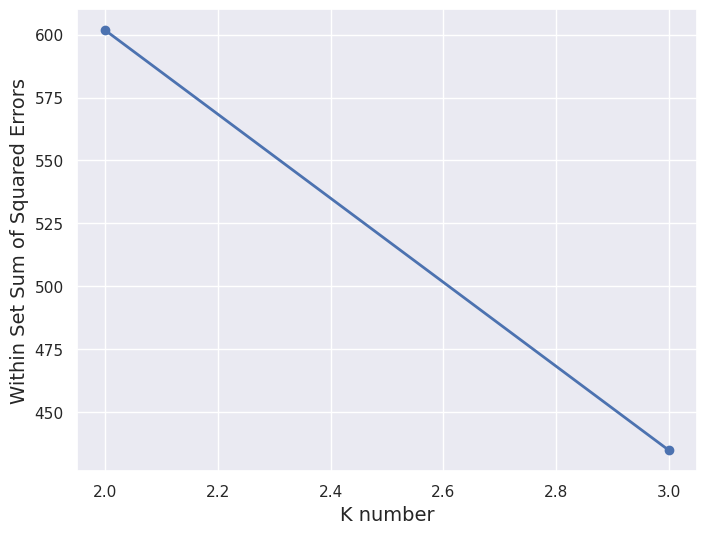

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(k_list, wsssse_list, '-o', linewidth=2)


ax.set_ylabel('Within Set Sum of Squared Errors', size=14)
ax.set_xlabel('K number', size=14)

plt.show()

In [29]:
best_k = 3

kmeans = KMeans(
seed=random_seed,
featuresCol = 'scaled_features',
k=best_k,
)

model = kmeans.fit(data_input)

In [30]:
model.clusterCenters()

[array([3.05623261, 2.95754486, 1.99757683, 3.2079628 , 4.49941976,
        3.26738378]),
 array([1.26023837, 1.31829808, 0.99280765, 1.36491885, 2.5625043 ,
        5.26676612]),
 array([2.93719177, 2.88492202, 0.        , 3.19938371, 4.52857793,
        3.30407351])]

In [31]:
predictions = model.transform(data_input)

In [32]:
predictions.show(6)

+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+--------------------+--------------------+----------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|            features|     scaled_features|prediction|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+--------------------+--------------------+----------+
|                    8.0|           391.09|              1|             2.96|            7.0|            Slovenia|           72.37|[8.0,391.09,1.0,2...|[0.56785108466505...|         1|
|                   20.0|           720.99|              0|             3.04|            9.0|British Virgin Is...|           69.08|[20.0,720.99,0.0,...|[1.41962771166263...|         1|
|                   31.0|           356.32|              1|             3.7

In [33]:
predictions.groupBy('prediction').agg({'prediction' : 'count'}).show()

+----------+-----------------+
|prediction|count(prediction)|
+----------+-----------------+
|         1|              167|
|         2|               79|
|         0|               88|
+----------+-----------------+



In [35]:
best_k = 2

kmeans = KMeans(
seed=random_seed,
featuresCol = 'scaled_features',
k=best_k,
)

model = kmeans.fit(data_input)

predictions = model.transform(data_input)

predictions.groupBy('prediction').agg({'prediction' : 'count'}).show()

+----------+-----------------+
|prediction|count(prediction)|
+----------+-----------------+
|         1|              167|
|         0|              167|
+----------+-----------------+

